## Goal

Train a Semantic Segmentation model in IceVision on the [FaceSynthetics](https://github.com/microsoft/FaceSynthetics) dataset and deploy in on NVIDIA Triton's server with Amazon SageMaker. 

A sample dataset with 1000 images (320MB) can be downloaded from [here](https://facesyntheticspubwedata.blob.core.windows.net/iccv-2021/dataset_1000.zip).

You can play with the (torchscript) model on [this](https://huggingface.co/spaces/frapochetti/blurry-faces) HuggingFace Space.

***

### How to run the notebook

Execute the following commands from within the `docker` folder.

You might need to change line 11 inside the `docker-compose.yaml` file to specify how the `root` volume is mounted. In my case, this is important to gain access to the `.aws` directory from within the running container and be able to signin `boto3` requests.
```
> docker-compose build
> docker-compose -f docker-compose.yaml -f docker-compose.gpu.yaml run --rm -d icetrt
```

Once the container is running, attach VSCode to it and run this notebook normally.

## Intro

### Imports

In [ ]:
from icevision.all import *
from PIL import Image, ImageOps

%matplotlib inline

I used the `dataset_1000.zip` sample from [FaceSynthetics](https://github.com/microsoft/FaceSynthetics) 

In [2]:
data_dir = Path("/home/ubuntu/data/faces_msft_1000") 
data_dir = data_dir if data_dir.exists() else Path("/root/data/faces_msft_1000") # if running in a docker container

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


### Helper functions

In [3]:
def binarize_image(path: Union[str, Path], overwrite: bool = False) -> None:
    if overwrite:
        o = np.array(Image.open(str(path).replace(".png", "_seg.png")))
        bin = np.ones(o.shape) * 255
        bin[(o==0) | (o==12) | (o==13) | (o==15) | (o==17) | (o==255)] = 0
        Image.fromarray(bin.astype("uint8")).convert("L").save(str(path).replace(".png", "_bin.png"))

def compute_size(img: Image.Image, new_size: int) -> Tuple[int, int]:
    w, h = img.size
    
    if w >= h:
        ratio = w/h
        new_w = new_size
        new_h = int(new_w * ratio)
    else:
        ratio = h/w
        new_h = new_size
        new_w = int(new_h * ratio)

    return new_h, new_w

def resize_with_padding(img: Image.Image, expected_size: Tuple[int, int]) -> Tuple[Image.Image, Tuple[int, int]]:
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding), (pad_width, pad_height)

def remove_padding(img: Union[np.ndarray, Image.Image], padding: Tuple[int, int]) -> Image.Image:
    pad_w, pad_h = padding
    img = np.array(img)
    img_w, img_h, _ = img.shape
    img = img[(pad_h):(img_h-pad_h), (pad_w):(img_w-pad_w), :]
    return Image.fromarray(img.astype(np.uint8))

def get_sample_image(path: Union[str, Path], 
                     size: int = 384,
                     keep_aspect_ratio: bool = True, 
                     pad: bool = True) -> Tuple[Image.Image, torch.tensor, list, Tuple[int, int]]:
    pil_img = Image.open(path).convert("RGB")
    
    if pad:
        pil_img, padding = resize_with_padding(pil_img, (size, size))
    else:
        if keep_aspect_ratio:
            h, w = compute_size(pil_img, size)
            pil_img = pil_img.resize((h, w))
        else:
            pil_img = pil_img.resize((size, size))
        
    img = (np.array(pil_img).astype(np.float32) / 255) - np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape(1, 1, 3)
    img = img / np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(1, 1, 3)
    img = np.transpose(img, (2, 0, 1))
    tensor_img = torch.tensor(img[None])
    list_img = img.tolist()
    return pil_img, tensor_img, list_img, padding

def get_sample_image_binary(input_name: str, output_name: str, shape: int, image_list: list) -> Tuple[bytes, int]:
    inputs = []
    outputs = []
    inputs.append(httpclient.InferInput(input_name, [1, 3, shape, shape], "FP32"))
    input_data = np.array(image_list, dtype=np.float32)
    input_data = np.expand_dims(input_data, axis=0)
    inputs[0].set_data_from_numpy(input_data, binary_data=True)
    outputs.append(httpclient.InferRequestedOutput(output_name, binary_data=True))
    request_body, header_length = httpclient.InferenceServerClient.generate_request_body(
        inputs, outputs=outputs
    )
    return request_body, header_length

def check_outputs(x1: torch.tensor, x2: torch.tensor) -> None: 
    equal_up_tp = torch.sum(x1.argmax(dim=1) == x2.argmax(dim=1))/x1.argmax(dim=1).numel()
    print(f"Mask predictions equal (pixelwise) at: {np.round(float(equal_up_tp) * 100, 3)}%")

def soft_blur_with_mask(image: Image.Image, mask: torch.tensor, padding: Tuple[int, int] = None) -> Image.Image:
    mask = mask.argmax(dim=1).cpu().numpy().squeeze()
    image = np.array(image)
    # Create a blurred copy of the original image.
    blurred_image = cv2.GaussianBlur(image, (221, 221), sigmaX=20, sigmaY=20)
    image_height, image_width = image.shape[:2]
    mask = cv2.resize(mask.astype(np.uint8), (image_width, image_height), interpolation=cv2.INTER_NEAREST)
    # Blurring the mask itself to get a softer mask with no firm edges
    mask = cv2.GaussianBlur(mask.astype(np.float32), (11, 11), 10, 10)[:, :, None]

    # Take the blurred image where the mask it positive, and the original image where the image is original
    image = (mask * blurred_image + (1.0 - mask) * image)
    if padding is not None:
        return remove_padding(image, padding)
    else: 
        return PIL.Image.fromarray(image.astype(np.uint8))

def visualize_mask(img: Image.Image, mask: torch.tensor, padding: Tuple[int, int] = None) -> Image.Image:
    cmap = rand_cmap(2, verbose=False)
    alpha = 0.5

    w, h = img.size
    mask_arr = np.zeros((h, w, 3), dtype=np.uint8)

    mask = mask.argmax(dim=1).cpu().numpy().squeeze()

    assert mask.shape == (h, w), (
        "image and mask size should be the same"
        f"but got image:{(w, h)}; mask: {(mask.shape[::-1])}"
    )

    for class_idx in np.unique(mask):
        mask_idxs = mask == class_idx
        mask_arr[mask_idxs] = np.array(cmap(class_idx)[:3]) * 255

    mask_pil = PIL.Image.fromarray(mask_arr)
    img = PIL.Image.blend(img, mask_pil, alpha=alpha)
    if padding is not None:
        return remove_padding(img, padding)
    else: 
        return img

def predict_with_model(path_to_img: Union[str, Path], 
                       size: int, 
                       model: torch.nn.Module, 
                       keep_aspect_ratio: bool = True, 
                       plot_mask: bool = True, 
                       blur_faces: bool = False,
                       remove_pad: bool = True) -> torch.tensor:
    model = model.eval().to(device)
    pil_img, tensor_img, _, padding = get_sample_image(path=path_to_img, size=size, keep_aspect_ratio=keep_aspect_ratio)
    tensor_img = tensor_img.to(device)

    with torch.inference_mode():
        mask = model(tensor_img)

    if blur_faces: 
        if remove_pad:
            return soft_blur_with_mask(pil_img, mask, padding)
        else:
            return soft_blur_with_mask(pil_img, mask)

    if plot_mask:
        if remove_pad:
            return visualize_mask(pil_img, mask, padding)
        else:
            return visualize_mask(pil_img, mask)
    
    return mask

## IceVision

### Preparing the dataset

In [4]:
image_files = get_image_files(data_dir)
image_files = [f for f in image_files if "seg" not in str(f) and "bin" not in str(f)]
for image_file in image_files: binarize_image(image_file)
len(image_files)

1000

In [5]:
class_map = ClassMap(["face"])
class_map

<ClassMap: {'background': 0, 'face': 1}>

In [6]:
records = RecordCollection(SemanticSegmentationRecord)

for image_file in pbar(image_files):
    record = records.get_by_record_id(image_file.stem)

    if record.is_new:
        record.set_filepath(image_file)
        record.set_img_size(get_img_size(image_file))
        record.segmentation.set_class_map(class_map)

    mask_file = SemanticMaskFile(str(image_file).replace(".png", "_bin.png"), binary=True)
    record.segmentation.set_mask(mask_file)
    
records = records.autofix()
train_records, valid_records = records.make_splits(RandomSplitter([0.8, 0.2]))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
len(train_records), len(valid_records)

(800, 200)

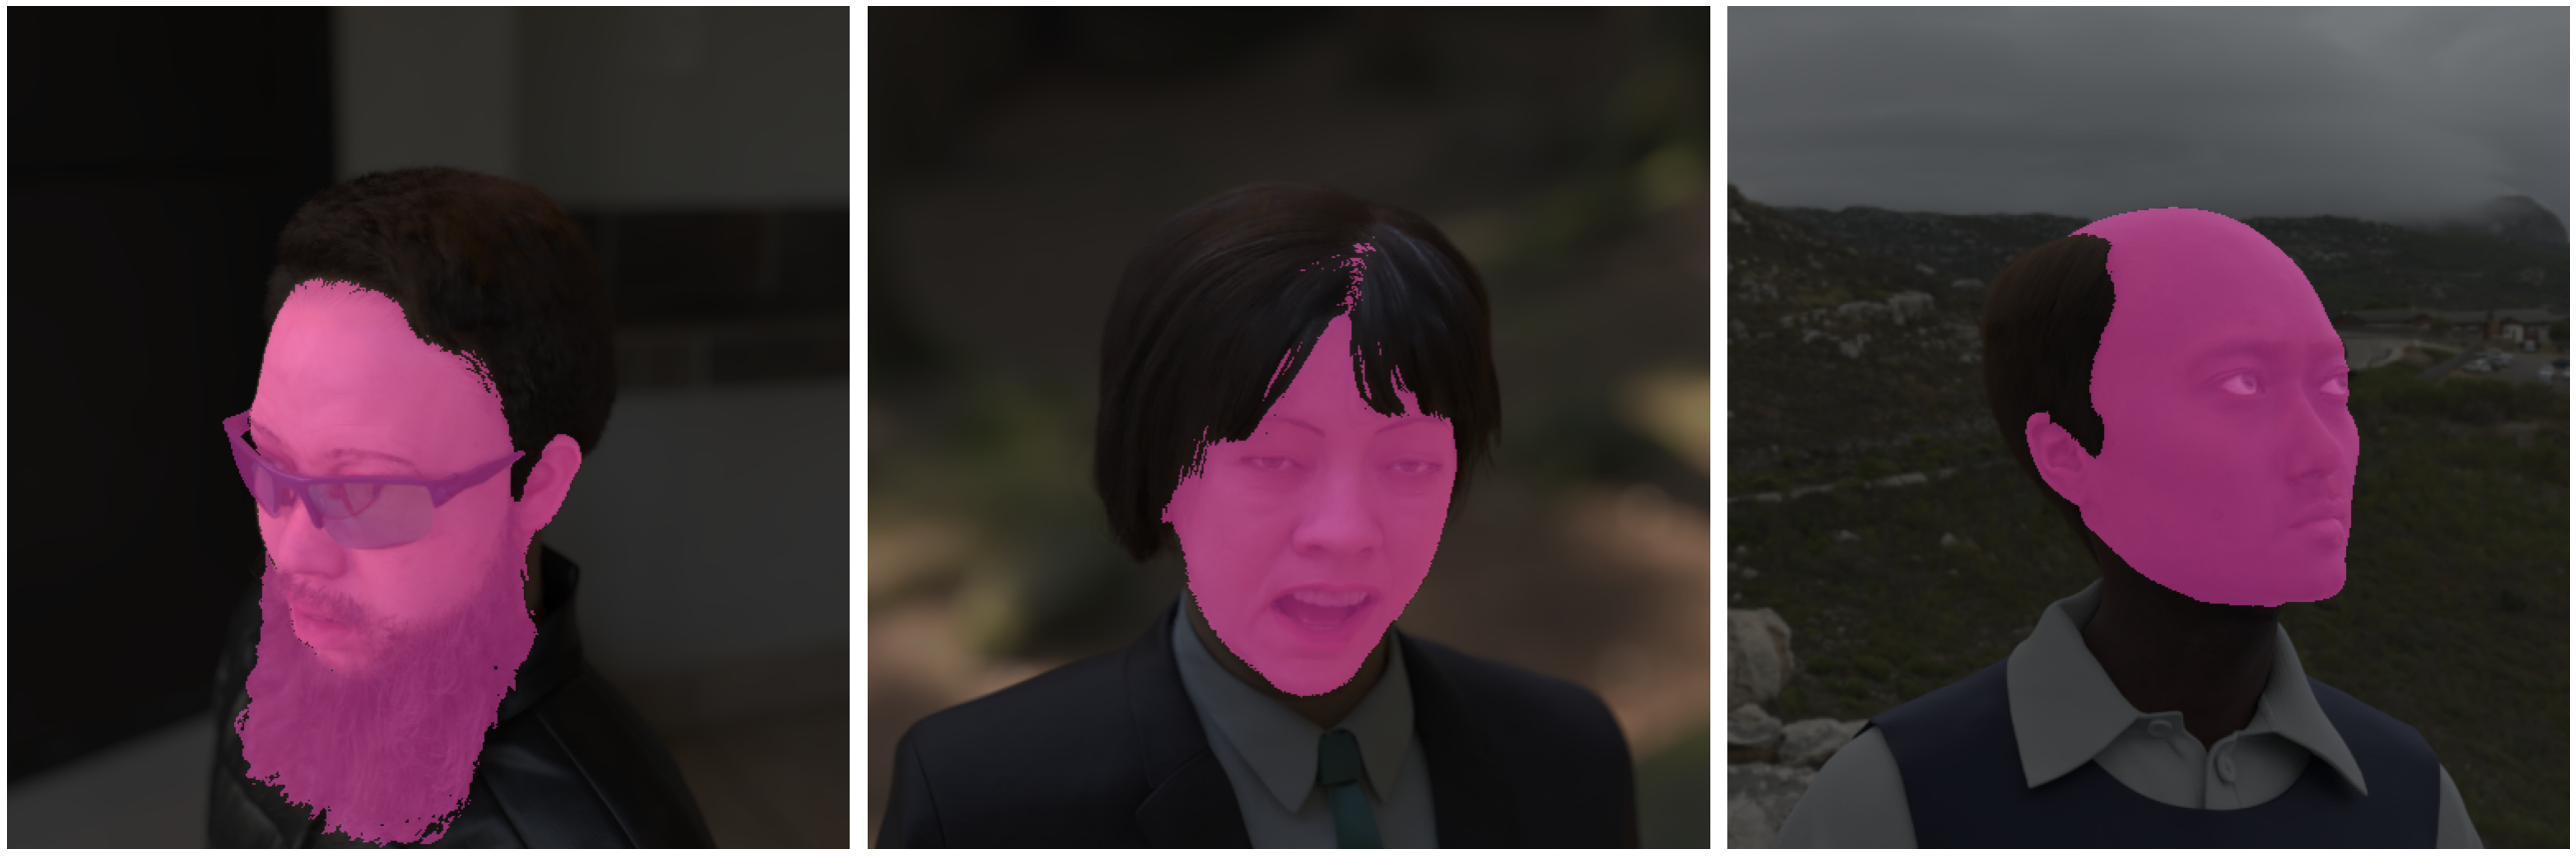

In [8]:
sample_records = random.choices(train_records, k=3)
show_records(sample_records, ncols=3)

### Defining transforms and datasets

In [9]:
presize, size = 512, 384

aug_tfms = tfms.A.aug_tfms(presize=presize, size=size, pad=None,
                           crop_fn=None,
                           shift_scale_rotate=tfms.A.ShiftScaleRotate(scale_limit=[-1.0, 1.0], rotate_limit=10, shift_limit=0.0625, p=1, border_mode=3),
                          )

train_tfms = tfms.A.Adapter([*aug_tfms, tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([tfms.A.resize(size), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

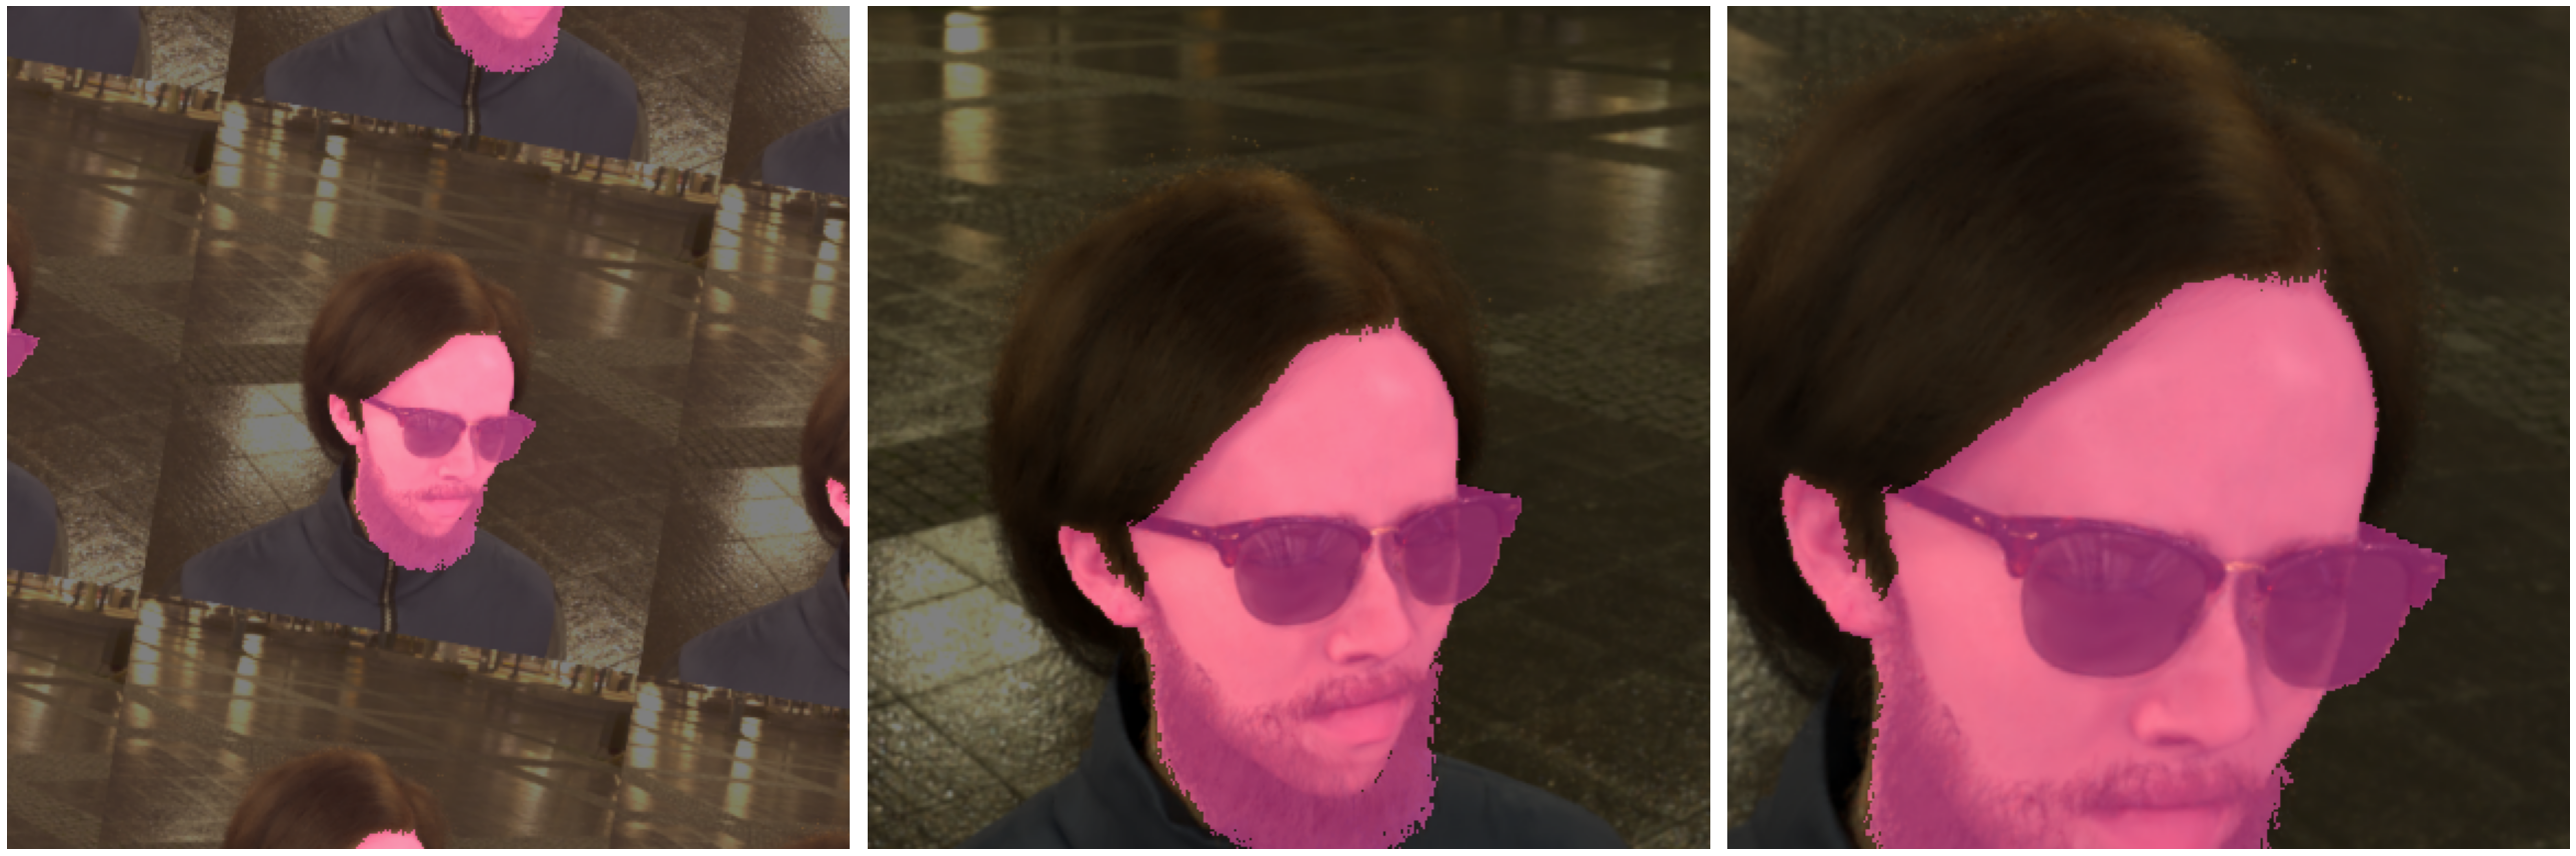

In [10]:
ds_samples = [train_ds[0] for _ in range(3)]
show_samples(ds_samples, ncols=3)

### Selecting the model: UNET with ResNet34 backbone

In [11]:
model_type = models.fastai.unet
backbone = model_type.backbones.resnet34(pretrained=True)
model = model_type.model(backbone=backbone, num_classes=2, img_size=384)

In [12]:
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=0, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=0, shuffle=False)

Taking a sneak peek into a batch

In [13]:
x, y = first(train_dl)

In [14]:
# images...
x[0].shape

torch.Size([16, 3, 384, 384])

In [15]:
# ... and masks
x[1].shape

torch.Size([16, 384, 384])

### Defining and training the `fastai` learner

In [16]:
from fastai.callback.tracker import SaveModelCallback

In [17]:
def accuracy_camvid(pred, target):
    # ignores background pixels
    keep_idxs = target != class_map.get_by_name('background')
    target = target[keep_idxs]
    pred = pred.argmax(dim=1)[keep_idxs]

    return (pred==target).float().mean() 

cbs = SaveModelCallback()
metrics = [accuracy_camvid]

In [18]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics, cbs=cbs)

### Train segmentation model...

SuggestedLRs(valley=6.30957365501672e-05)

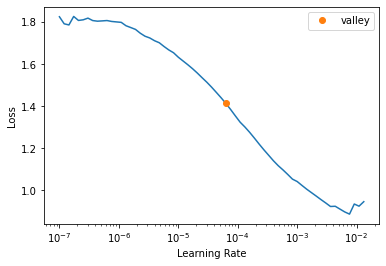

In [19]:
learn.lr_find()

In [26]:
learn.fine_tune(30, 1e-4)

Better model found at epoch 0 with valid_loss value: 0.12434839457273483.


Better model found at epoch 0 with valid_loss value: 0.057342082262039185.
Better model found at epoch 1 with valid_loss value: 0.054278966039419174.
Better model found at epoch 2 with valid_loss value: 0.04497873783111572.
Better model found at epoch 3 with valid_loss value: 0.04168803617358208.
Better model found at epoch 5 with valid_loss value: 0.04028976336121559.
Better model found at epoch 6 with valid_loss value: 0.03542615845799446.
Better model found at epoch 7 with valid_loss value: 0.030620861798524857.
Better model found at epoch 9 with valid_loss value: 0.02892843261361122.
Better model found at epoch 10 with valid_loss value: 0.028880752623081207.
Better model found at epoch 11 with valid_loss value: 0.02694871835410595.
Better model found at epoch 12 with valid_loss value: 0.026106316596269608.
Better model found at epoch 14 with valid_loss value: 0.024847621098160744.
Better model found at epoch 15 with valid_loss value: 0.02405407652258873.
Better model found at epoch

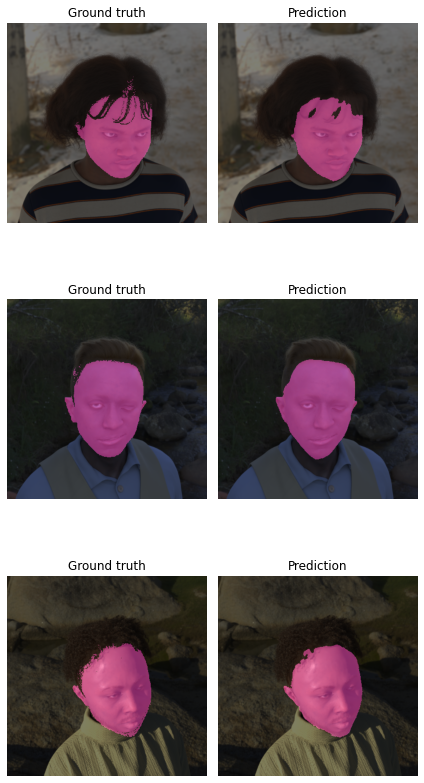

In [16]:
model_type.show_results(model, valid_ds, num_samples=3)

### ... or load already trained model

Load the learner directly...

In [19]:
learn.load(file="model")

/home/ubuntu/anaconda3/envs/ice/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


... or the model only ...

In [20]:
model_type = models.fastai.unet
backbone = model_type.backbones.resnet34(pretrained=True)
model = model_type.model(backbone=backbone, num_classes=2, img_size=384)

In [21]:
model.load_state_dict(torch.load("./models/model.pth"))

<All keys matched successfully>

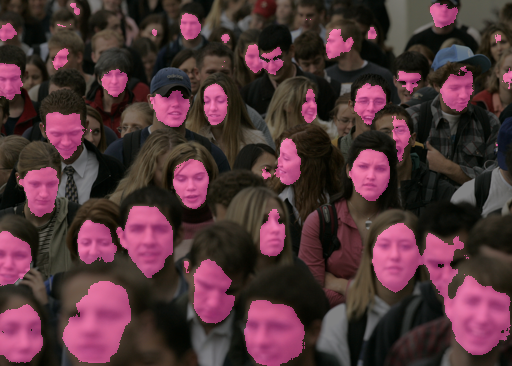

In [26]:
predict_with_model("./sample_faces/crowd1.jpeg", size=512, model=model, plot_mask=True)

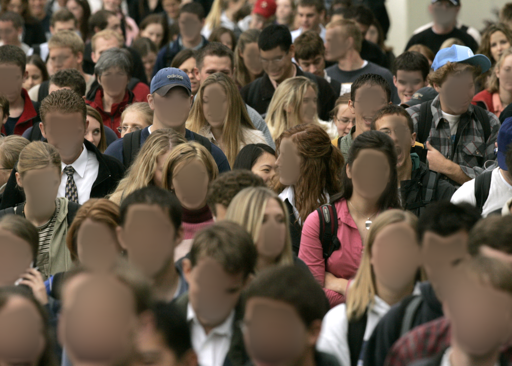

In [32]:
predict_with_model("./sample_faces/crowd1.jpeg", size=512, model=model, blur_faces=True)

... or load from TorchScript

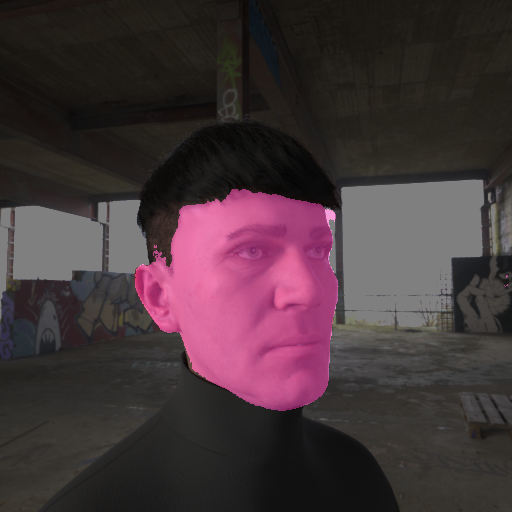

In [28]:
model = torch.jit.load("./ice_mask_torchscript/model/model.pt")
predict_with_model("./sample_faces/single_face.png", size=512, model=model, plot_mask=True)

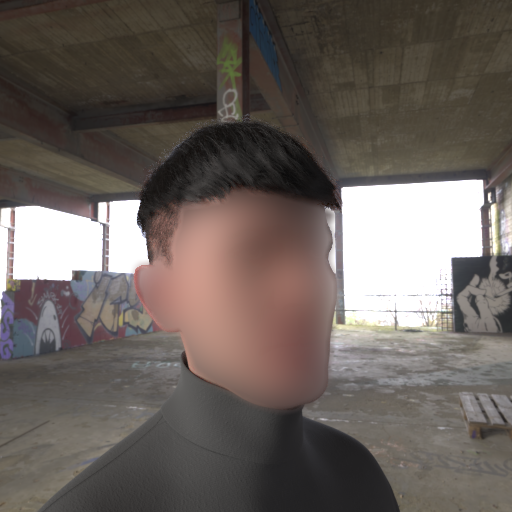

In [30]:
predict_with_model("./sample_faces/single_face.png", size=512, model=model, blur_faces=True)

### Once the model has been trained, we can:

#### 1. Save to TorchScript

In [24]:
dummy_inp = torch.randn([1, 3, 512, 512])
dummy_inp.shape

torch.Size([1, 3, 512, 512])

In [ ]:
torch.jit.save(torch.jit.trace(learn.model, dummy_inp), './ice_mask_torchscript/model/model.pt')

Checking if the TorchScripted model and the original fastai model yield same results

In [20]:
pil_img, tensor_img, _, padding = get_sample_image("./sample_faces/girls.jpeg", size=512, pad=True)
tensor_img.shape

torch.Size([1, 3, 512, 512])

In [21]:
with torch.inference_mode():
    x_from_learn = learn.model(tensor_img)
x_from_learn.shape

torch.Size([1, 2, 512, 512])

In [22]:
%%timeit
with torch.inference_mode(): _ = learn.model(tensor_img)

2.11 s ± 66.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
model_jit =  torch.jit.load("./ice_mask_torchscript/model/model.pt")
with torch.inference_mode():
    x_from_jit = model_jit(tensor_img)
x_from_jit.shape

torch.Size([1, 2, 512, 512])

In [24]:
%%timeit
with torch.inference_mode(): _ = model_jit(tensor_img)

2.12 s ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
check_outputs(x_from_learn, x_from_jit)

Mask predictions equal (pixelwise) at: 100.0%


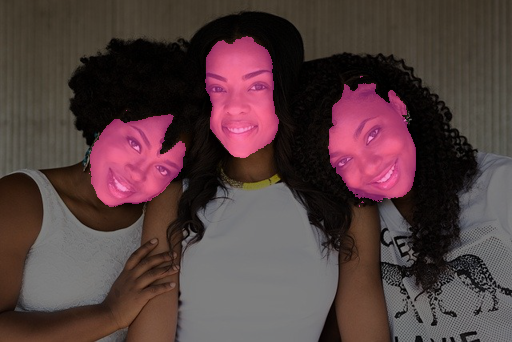

In [42]:
visualize_mask(pil_img, x_from_learn, padding=padding)

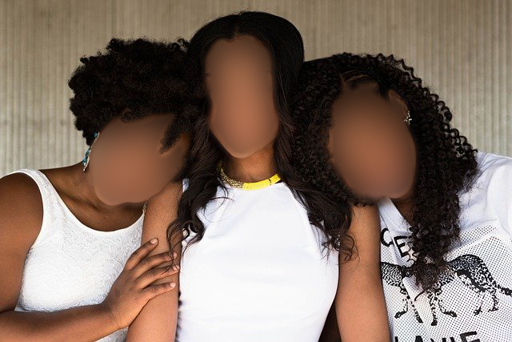

In [43]:
soft_blur_with_mask(pil_img, x_from_learn, padding=padding)

#### 2. Convert to ONNX

In [29]:
img = torch.rand([1, 3, 512, 512])
img.shape

torch.Size([1, 3, 512, 512])

In [ ]:
eval_model = learn.model.eval()

torch.onnx.export(
    eval_model,
    img,
    "model.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size", 2:'height', 3:'width'}, 
                  "output": {0: "batch_size", 2:'height', 3:'width'}},
)

In [27]:
import onnx
import onnxruntime as ort

onnx_model = onnx.load("model.onnx")
onnx.checker.check_model(onnx_model)

Checking if the ONNX model and the original fastai model yield same results

In [28]:
pil_img, tensor_img, _, padding = get_sample_image("./sample_faces/girls.jpeg", size=512, pad=True)
tensor_img.shape

torch.Size([1, 3, 512, 512])

In [49]:
ort_sess = ort.InferenceSession('model.onnx')
outputs = ort_sess.run(None, {'input': tensor_img.cpu().numpy()})
torch.tensor(outputs[0]).shape

torch.Size([1, 2, 512, 512])

In [51]:
onnx_input = tensor_img.cpu().numpy()

In [52]:
%%timeit
_ = ort_sess.run(None, {'input': onnx_input})

1.42 s ± 170 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


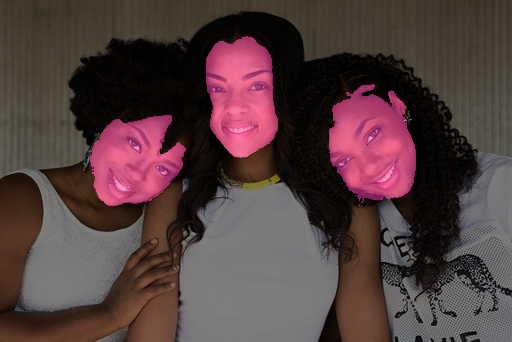

In [53]:
visualize_mask(pil_img, torch.tensor(outputs[0]), padding=padding)

In [54]:
check_outputs(x_from_learn, torch.tensor(outputs[0]))

Mask predictions equal (pixelwise) at: 99.773%


In [33]:
check_outputs(x_from_jit, torch.tensor(outputs[0]))

Mask predictions equal (pixelwise) at: 99.773%


Great! Both the original fastai model and the TorschScripted version return the same result as ONNX.

#### 3. Convert to TensorRT

In [ ]:
!trtexec --onnx=model.onnx --saveEngine=model.plan --explicitBatch --minShapes=input:1x3x512x512 --optShapes=input:1x3x512x512 --maxShapes=input:1x3x512x512 --int8 --verbose | tee conversion.txt

## Deploying to SageMaker

Largely inspired by [this](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-triton/resnet50/triton_resnet50.ipynb) official AWS notebook.

In [ ]:
import boto3, json, sagemaker, time
import tritonclient.http as httpclient

sm_client = boto3.client(service_name="sagemaker")
runtime_sm_client = boto3.client("sagemaker-runtime")
sagemaker_session = sagemaker.Session(boto_session=boto3.Session())
role = "IAM role with SageMaker and S3 permissions"
region = boto3.Session().region_name

base = "amazonaws.com"
triton_image_uri = "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:21.08-py3".format(account_id='802834080501', region=region, base=base)
triton_image_uri

### Deploying the TorchScript model

In [5]:
!cd ice_mask_torchscript/model && tar czvf ../model.tar.gz *

model.pt


In [6]:
model_uri = sagemaker_session.upload_data(path="./ice_mask_torchscript/model.tar.gz", key_prefix="ice_mask_torchscript")
print(model_uri)

s3://sagemaker-eu-west-1-257446244580/ice_mask_torchscript/model.tar.gz


In [21]:
from sagemaker.pytorch import PyTorchModel

model = PyTorchModel(
              role=role,
              name="ice-mask-torchscript",
              sagemaker_session=sagemaker_session,
              model_data="s3://sagemaker-eu-west-1-257446244580/ice_mask_torchscript/model.tar.gz",
              framework_version='1.10',
              py_version='py38',
              entry_point="serve.py",
              source_dir="ice_mask_torchscript",
              )

predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge",
    endpoint_name="ice-mask-torchscript",
)

Creating model with name: ice-mask-torchscript
Creating endpoint-config with name ice-mask-torchscript
Creating endpoint with name ice-mask-torchscript
---------!

In [22]:
pil_img, tensor_img, _, padding = get_sample_image("./sample_faces/girls.jpeg", size=512, pad=True)
tensor_img.shape

torch.Size([1, 3, 512, 512])

In [27]:
from sagemaker.pytorch.model import PyTorchPredictor
torchscript_predictor = PyTorchPredictor(endpoint_name="ice-mask-torchscript", sagemaker_session=sagemaker_session)

In [28]:
pred_from_sage_ts = torchscript_predictor.predict(tensor_img)
pred_from_sage_ts.shape

(1, 2, 512, 512)

In [29]:
model_jit =  torch.jit.load("./ice_mask_torchscript/model/model.pt")
x_from_jit = model_jit(tensor_img)
x_from_jit.shape

torch.Size([1, 2, 512, 512])

In [30]:
check_outputs(x_from_jit, torch.tensor(pred_from_sage_ts))

Mask predictions equal (pixelwise) at: 100.0%


Great! The local TorschScript model and its AWS counterpart return the same result.

In [31]:
#warming up the model
for _ in range(10): _ = torchscript_predictor.predict(tensor_img)

In [38]:
%%timeit
# PLAIN TORCHSCRIPT
_ = torchscript_predictor.predict(tensor_img)

201 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Deploying the TensorRT model to Triton

Packaging the model as expected by SageMaker and Triton

In [33]:
!mkdir -p triton-serve-trt/unet/1/
!cp -f model.plan triton-serve-trt/unet/1/model.plan
!tar -C triton-serve-trt/ -czf model.tar.gz unet

Uploading model artifact to S3

In [34]:
model_uri = sagemaker_session.upload_data(path="model.tar.gz", key_prefix="triton-serve-trt")
model_uri

's3://sagemaker-eu-west-1-257446244580/triton-serve-trt/model.tar.gz'

Creating model

In [35]:
sm_model_name = "triton-unet-trt"

container = {
    "Image": triton_image_uri,
    "ModelDataUrl": "s3://sagemaker-eu-west-1-257446244580/triton-serve-trt/model.tar.gz",
    "Environment": {"SAGEMAKER_TRITON_DEFAULT_MODEL_NAME": "unet"},
}

create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:eu-west-1:257446244580:model/triton-unet-trt


Creating endpoint config

In [36]:
endpoint_config_name = "triton-unet-trt"

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.g4dn.xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:eu-west-1:257446244580:endpoint-config/triton-unet-trt


Creating endpoint

In [37]:
endpoint_name = "triton-unet-trt"

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:eu-west-1:257446244580:endpoint/triton-unet-trt


### TensorRT: Run inference

In [39]:
size = 512
pil_img, tensor_img, list_img, padding = get_sample_image("./sample_faces/girls.jpeg", size=size, pad=True)
tensor_img.shape

torch.Size([1, 3, 512, 512])

In [40]:
request_body, header_length = get_sample_image_binary("input", "output", size, list_img)

response = runtime_sm_client.invoke_endpoint(
    EndpointName="triton-unet-trt",
    ContentType="application/vnd.sagemaker-triton.binary+json;json-header-size={}".format(
        header_length
    ),
    Body=request_body,
)

# Parse json header size length from the response
header_length_prefix = "application/vnd.sagemaker-triton.binary+json;json-header-size="
header_length_str = response["ContentType"][len(header_length_prefix) :]

# Read response body
result = httpclient.InferenceServerClient.parse_response_body(
    response["Body"].read(), header_length=int(header_length_str)
)
x_trt = result.as_numpy("output")
x_trt.shape

(1, 2, 512, 512)

In [42]:
check_outputs(x_from_jit, torch.tensor(x_trt))

Mask predictions equal (pixelwise) at: 99.67%


This is great! 
* Previous cell: the local TorschScript model and the TRT network deployed on Triton return the same result.
* Following cell: the TRT model deployed on Triton works perfectly! The vis looks good.

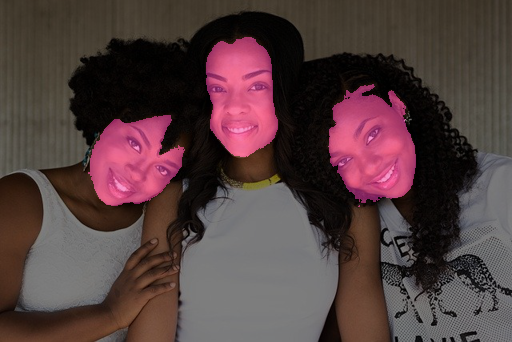

In [43]:
visualize_mask(pil_img, torch.tensor(x_trt), padding=padding)

In [44]:
#warming up the model
#probably not necessary as in config.pbtxt file we specify to perform warmup
for _ in range(10):
    response = runtime_sm_client.invoke_endpoint(
        EndpointName="triton-unet-trt",
        ContentType="application/vnd.sagemaker-triton.binary+json;json-header-size={}".format(
            header_length
        ),
        Body=request_body,
    )

### Comparing end2end latency of Triton VS TorchScript endpoint

In [49]:
%%timeit
# PLAIN TORCHSCRIPT
_ = torchscript_predictor.predict(tensor_img)

199 ms ± 4.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
%%timeit
# TRITON
response = runtime_sm_client.invoke_endpoint(
    EndpointName="triton-unet-trt",
    ContentType="application/vnd.sagemaker-triton.binary+json;json-header-size={}".format(
        header_length
    ),
    Body=request_body,
)

140 ms ± 4.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
print(f"Triton is {np.round(-(140/200 - 1)*100, 2)}% faster wrt TorchScript in end2end latency")

Triton is 30.0% faster wrt TorchScript in end2end latency


This is already not bad, but if we look at the model latency measured inside by AWS CloudWatch, e.g. excluding networking overhead we get the following:
* **Triton**: 15.5 ms
* **TorchScript**: 130 ms 

which translates to...

In [60]:
print(f"Triton is {np.round(130/15.5, 2)}x faster wrt TorchScript in end2end latency")

Triton is 8.39x faster wrt TorchScript in end2end latency


Truly spectacular!

#### Quick test to hit the endpoint with multiple concurrent requests

In [22]:
import threading
import time

num_preds = 2000
num_threads = 10
times = []

def predict():
    thread_id = threading.get_ident()
    print(f'Thread {thread_id} started')
    
    for i in range (num_preds):
        tick = time.time()
        _ = runtime_sm_client.invoke_endpoint(
                                EndpointName="triton-unet-trt",
                                ContentType="application/vnd.sagemaker-triton.binary+json;json-header-size={}".format(
                                    header_length
                                ),
                                Body=request_body,
                            )
        tock = time.time()
        times.append((thread_id, tock-tick))


for i in range(num_threads): threading.Thread(target=predict, daemon=False).start()

Thread 139837080332032 startedThread 139837306803968 started

Thread 139837340374784 started
Thread 139837071939328 started
Thread 139838533609216 started
Thread 139838525216512 started
Thread 139837884069632 started
Thread 139837875676928 started
Thread 139837867284224 started
Thread 139837858891520 started
